# Missing Block Cross Validation

Leave out a block of data and predict the withheld data. Models include cokriging, kriging,
and trend-only prediction

In [1]:
import sys

sys.path.insert(0, "../../source")


In [2]:
from copy import deepcopy
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import plot
import prediction
import validation


In [3]:
from dask.distributed import Client

# NOTE: update depending on which node is used
N_WORKERS = 84
client = Client(n_workers=N_WORKERS)


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37447 instead
  warnings.warn(
2023-06-12 18:02:21,066 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-32desxxw', purging
2023-06-12 18:02:21,066 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h_nlucb7', purging
2023-06-12 18:02:21,066 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-0sqatfo6', purging
2023-06-12 18:02:21,066 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-s84rramu', purging
2023-06-12 18:02:21,066 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8d37dks4', purging
2023-06-12 18:02:21,066 - distributed.diskutils

In [4]:
# number of nearest observations used in point predictions
NUM_LOCAL_VALUES = 150

# data selection
YEAR = 2021
MONTH = 2
# XCO2 months ahead of SIF
OFFSET = 1

year_month_str = f"{YEAR}0{MONTH}" if MONTH < 10 else f"{YEAR}{MONTH}"


In [5]:
month_xco2 = MONTH + OFFSET
date_sif = f"{YEAR}-{MONTH}-01"
date_xco2 = f"{YEAR}-{month_xco2}-01"

with xr.open_dataset(
    "../../data/production/OCO2_005deg_monthly_north_america_with_basis.nc4"
) as ds:
    basis_vars = [x for x in list(ds.keys()) if x.startswith("B")]
    ds_sif = ds[["sif", "sif_var"] + basis_vars].sel(time=f"{YEAR}-{MONTH}").squeeze()


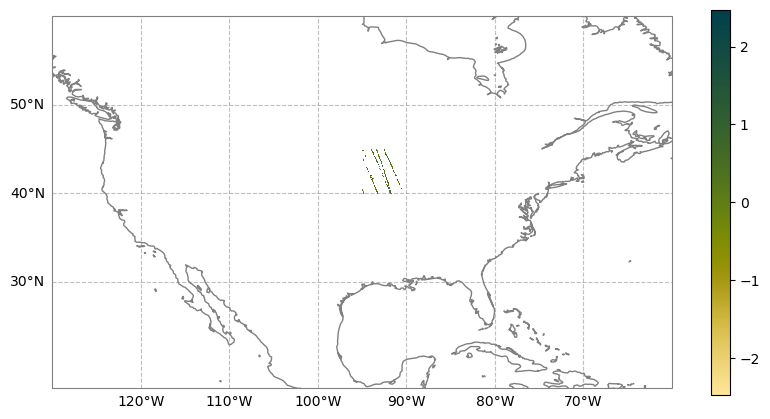

In [6]:
BLOCK_NAME = "b1"
block_conditions = (
    (ds_sif["lon"] > -95) & (ds_sif["lon"] < -90) & (ds_sif["lat"] > 40) & (ds_sif["lat"] < 45)
)
ds_test = ds_sif.where(block_conditions)

plot.plot_da(ds_test["sif"])


In [7]:
df_test = (
    ds_test.to_dataframe()
    .dropna(subset="sif")
    .reset_index()[["lat", "lon", "sif", "sif_var"] + basis_vars]
    .rename(columns={"sif": "data", "sif_var": "measurement_error"})
)
df_measurement_error = df_test.loc[:, ["lat", "lon", "measurement_error"]]
df_test = df_test.drop(columns="measurement_error")
ds_covariates = (
    df_test.set_index(["lat", "lon"]).to_xarray().drop_vars(["data", "B1", "B10", "B20"])
)
df_test = df_test.loc[:, ["lat", "lon", "data"]]
pcoords = df_test.loc[:, ["lat", "lon"]]
df_test.to_csv(f"../../data/production/validation/{year_month_str}/df_test_{BLOCK_NAME}.csv")
df_test


,lat,lon,data
0,40.025,-94.825,-0.232284
1,40.025,-94.775,-0.010717
2,40.025,-93.275,0.456127
3,40.025,-93.225,-0.078473
4,40.025,-91.825,1.154629
...,...,...,...
680,44.975,-93.925,-0.170471
681,44.975,-93.375,-0.318110
682,44.975,-93.325,-0.359862
683,44.975,-92.525,0.166264


In [8]:
ds_covariates


<xarray.Dataset>
Dimensions:  (lat: 100, lon: 85)
Coordinates:
  * lat      (lat) float64 40.02 40.07 40.12 40.17 ... 44.82 44.87 44.92 44.97
  * lon      (lon) float64 -94.97 -94.92 -94.87 -94.82 ... -90.57 -90.52 -90.47
Data variables: (12/57)
    B2       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B3       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B4       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B5       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B6       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B7       (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    ...       ...
    B55      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B56      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B57      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B58      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B59      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan
    B60      (lat, lon) float64 nan nan nan 0.0 0.0 nan ... nan nan nan nan nan

<AxesSubplot:ylabel='Count'>

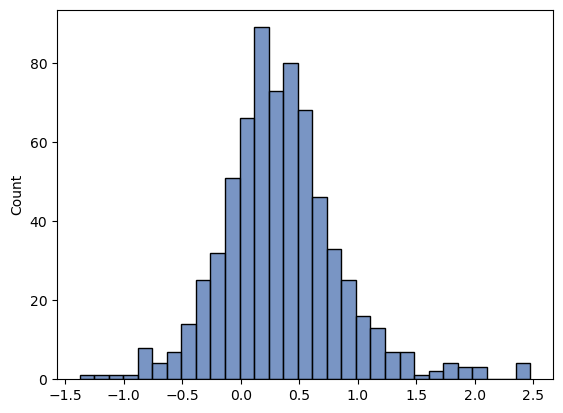

In [9]:
sns.histplot(df_test["data"].values)


## Cokriging

In [10]:
# Load multifield and model objects
with open(f"../../data/production/models/{year_month_str}/fields.pickle", "rb") as f:
    mf = pickle.load(f)

with open(f"../../data/production/models/{year_month_str}/bivariate_model.pickle", "rb") as f:
    bivariate_matern = pickle.load(f)


In [11]:
# Make validation predictions
cokrige = prediction.Predictor(bivariate_matern, mf)
dict_cokrige = cokrige.validation_prediction(
    0,
    pcoords,
    df_measurement_error,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_cokrige = dict_cokrige["ds"]
ds_cokrige


INFO | root:_compute_prediction_covariance_matrix:474 | Running predictive covariance


In [ ]:
# Save multivariate predictive distribution
pd.DataFrame(dict_cokrige["predictive_mean"]).to_csv(
    f"../../data/production/validation/{year_month_str}/mean_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_cokrige["predictive_covariance_matrix"]).to_csv(
    f"../../data/production/validation/{year_month_str}/covariance_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [ ]:
# Prepare validation results
df_cokrige = (
    ds_cokrige.to_dataframe().reset_index()[["lat", "lon", "predictions", "rmspe"]].dropna()
)

df_test_cokrige = validation.prepare_validation_results(
    df_cokrige,
    df_test,
    method="cokriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_cokrige = sm.ProbPlot(df_test_cokrige["ratio"].values)
df_quantiles_cokrige = pd.DataFrame(
    dict(
        sample=quantiles_cokrige.sample_quantiles,
        theoretical=quantiles_cokrige.theoretical_quantiles,
        Method="Cokriging",
    )
)


## Kriging

In [ ]:
client.close()


In [ ]:
client = Client(n_workers=N_WORKERS)


In [ ]:
# Isolate SIF field only
mf_univariate = deepcopy(mf)
mf_univariate.fields = np.array([mf_univariate.fields[0]])
mf_univariate.n_procs = 1

# Load univariate model
with open(f"../../data/production/models/{year_month_str}/univariate_model.pickle", "rb") as f:
    univariate_matern = pickle.load(f)


In [ ]:
# Make validation predictions
krige = prediction.Predictor(univariate_matern, mf_univariate)
dict_krige = krige.cross_validation(
    0,
    pcoords,
    df_measurement_error,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_krige = dict_krige["ds"]
ds_krige


In [ ]:
# Save multivariate predictive distribution
pd.DataFrame(dict_krige["predictive_mean"]).to_csv(
    f"../../data/production/validation/{year_month_str}/mean_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_krige["predictive_covariance_matrix"]).to_csv(
    f"../../data/production/validation/{year_month_str}/covariance_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [ ]:
# Prepare validation results
df_krige = (
    ds_krige.to_dataframe().reset_index()[["lat", "lon", "predictions", "rmspe"]].dropna()
)

df_test_krige = validation.prepare_validation_results(
    df_krige,
    df_test,
    method="kriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_krige = sm.ProbPlot(df_test_krige["ratio"].values)
df_quantiles_krige = pd.DataFrame(
    dict(
        sample=quantiles_krige.sample_quantiles,
        theoretical=quantiles_krige.theoretical_quantiles,
        Method="Kriging",
    )
)


## Trend-only

In [ ]:
# Prepare validation results
df_trend = (
    ds_krige.to_dataframe()
    .reset_index()[["lat", "lon", "trend_surface", "trend_surface_rmspe"]]
    .dropna()
    .rename(columns={"trend_surface": "predictions", "trend_surface_rmspe": "rmspe"})
)

df_test_trend = validation.prepare_validation_results(
    df_trend,
    df_test,
    method="Trend surface",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_trend = sm.ProbPlot(df_test_trend["ratio"].values)
df_quantiles_trend = pd.DataFrame(
    dict(
        sample=quantiles_trend.sample_quantiles,
        theoretical=quantiles_trend.theoretical_quantiles,
        Method="Trend surface",
    )
)


In [ ]:
# Save multivariate predictive distribution
df_test_trend["predictions"].to_csv(
    f"../../data/production/validation/{year_month_str}/mean_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)
pd.DataFrame(np.diag(df_test_trend["rmspe"].values ** 2)).to_csv(
    f"../../data/production/validation/{year_month_str}/covariance_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


## Collect results

In [ ]:
df_validation_results = pd.concat(
    [df_test_trend, df_test_krige, df_test_cokrige], axis=0
).reset_index(drop=True)
df_validation_results.to_csv(
    f"../../data/production/validation/{year_month_str}/validation_results_{BLOCK_NAME}.csv"
)
df_validation_results


In [ ]:
df_quantiles = pd.concat(
    [df_quantiles_trend, df_quantiles_krige, df_quantiles_cokrige], axis=0
).reset_index(drop=True)
df_quantiles.to_csv(
    f"../../data/production/validation/{year_month_str}/validation_ratio_quantiles_{BLOCK_NAME}.csv"
)

df_quantiles
